In [1]:
from astropy.io import fits #astropy modules for FITS IO
import numpy as np #numpy gives us better array management 
from scipy import interpolate #spline interpolation

In [2]:
import matplotlib  #ploting
matplotlib.use("Agg")  #some hack to stop the bouncing python icon when plotting
import matplotlib.pyplot as plt
#next line is to show plots inline with jupyter
#%matplotlib inline 
from matplotlib.colors import LogNorm #for better display of FITS images

In [3]:
%matplotlib inline

## Model Parameters

In [4]:
#Image Dimensions
xout=2048     #dispersion axis
yout=256      #spatial axis
#Simulation Parameters
snr=1000      #S/N of spectrum - move to commandline
rv=0.0        #radial velocity shift (m/s)
b=0.1         #impact parameter of planet
smodeltype=1  #1=Atlas-9+NL limbdarkening
starmodel_file="../samples/t3500l50z0_ldnl.dat" #star spectral model to use
pmodeltype=1  #1=Benneke
planetmodel_file="../samples/hd209458.csv"      #planet transit-spectral model
noversample=1 #oversampling 


In [5]:
import specgen as sp

## Get Instrument Response 

In [6]:
response_ld,response_n1,response_n2,response_n3=sp.readresponse()

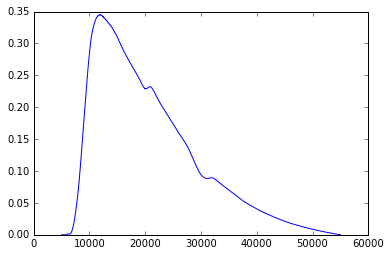

In [7]:
plt.plot(response_ld,response_n1)
plt.show()

## Read in Spectral Model

In [8]:
starmodel_wv,starmodel_flux=sp.readstarmodel(starmodel_file,smodeltype)

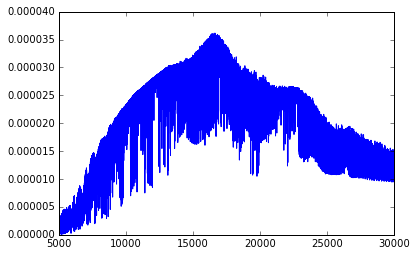

In [9]:
plt.plot(starmodel_wv,starmodel_flux)
plt.show()

In [10]:
planetmodel_wv,planetmodel_depth=sp.readplanetmodel(planetmodel_file,pmodeltype)

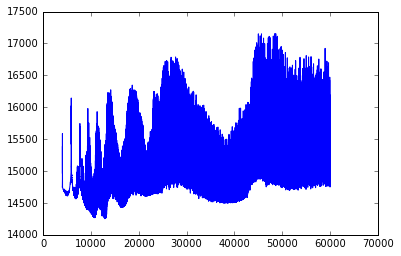

In [11]:
plt.plot(planetmodel_wv,planetmodel_depth)
plt.show()

In [12]:
sp.p2w(1,1,1)

26008.951918913997

In [13]:
sp.w2p(24000,1,1)

205.8151820800008

In [14]:
pixels=np.zeros((xout*noversample,yout*noversample))
pixelnorm=np.zeros((xout*noversample,yout*noversample))

In [15]:
response_spl = interpolate.splrep(response_ld, response_n1, s=0)
rmax=np.max(response_ld)
rmin=np.min(response_ld)
for k in range(starmodel_wv.shape[0]):
    
    w=starmodel_wv[k]
    i=sp.w2p(w,noversample,1)
    j=sp.ptrace(i,noversample,1)
    if w < rmax and w > rmin:
        response_one = interpolate.splev(w, response_spl, der=0)
    else:
        response_one = 0
    flux=starmodel_flux[k]*response_one
    pixels,pixelnorm=sp.addflux2pix(i,j,pixels,pixelnorm,flux)
    #if(i<2048):
    #    print(i,j,flux)
    #    input()
    
#Normalized the drizzled pixels
pixels=pixels/np.ma.array(pixelnorm,mask=(pixelnorm==0))

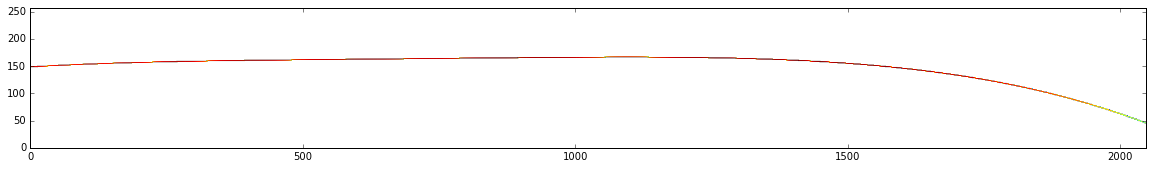

In [16]:
plt.figure(figsize=(20,4)) #adjust size of figure
imgplot = plt.imshow(np.transpose(pixels),norm=LogNorm())
plt.axis((0,pixels.shape[0],0,pixels.shape[1]))
plt.show()

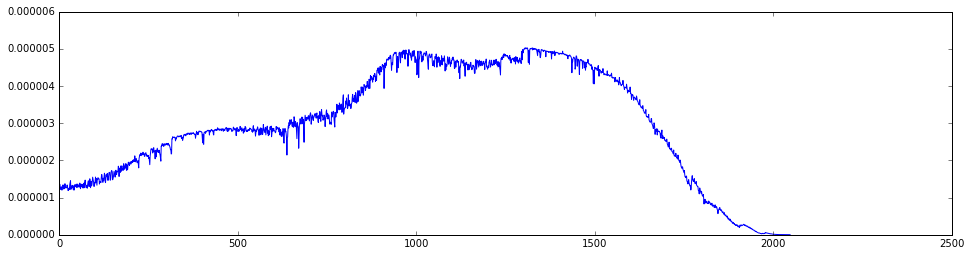

In [17]:
plt.figure(figsize=(16,4)) #adjust size of figure
plt.plot(np.sum(pixels,axis=1),label='Column Sum') #Plot the sum of each column
plt.show()